# Future Impact of Ocean Acidification on Coral Reefs in the Great Barrier Reef
Team 35 : Angelina Shalupova and Sophie Louie

## Executive Summary
Science has proven that an increase in carbon dioxide emissions into the atmosphere will inherently lower the pH of the ocean water. The lower the pH indicates the acidity of the water, more acidic water is detrimental to the health of many underwater organisms including coral which house millions of species. Our model predicts CO2 emissions until the year 2050 by taking into account the direction of the five previous years. The predicted CO2 data is then used as one of the factors to predict seawater pH (along side it's previous five years data). Finally, the pH and mean calcification rate of the five previous years is used to predict the future calcification rate of coral. Our model claims CO2 emissions will increase by 53 (MtC) as seen [here](#co2_cell), pH will decrease 0.0825 as seen [here](#ph_cell), and coral growth will decline by 0.2 (g/$cm^2$/yr) by the year 2050 as seen [here](#result_cell).

## Introduction

Carbon dioxide (CO2) emissions in the atmosphere have been increasing ever since the Industrial Revolution due to an increase of burning fossil fuels for energy. Not only is this increase the cause of global warming, it is also affecting the oceans. When the ocean absorbs CO2, various chemical reactions happen that lower the pH level of the ocean. This is known as ocean acidification. Since there has been an increase in CO2 in the atmosphere, the ocean has been absorbing more CO2, ultimately decreasing the pH levels: "Since the beginning of the Industrial Revolution, the pH of surface ocean waters has fallen by 0.1 pH units. Since the pH scale, like the Richter scale, is logarithmic, this change represents approximately a 30 percent increase in acidity." ([Source](https://www.pmel.noaa.gov/co2/story/What+is+Ocean+Acidification%3F)).
One ecosystem directly impacted by ocean acidification is coral reefs. Specifically, ocean acidification impacts coral calcification, which is a measure of coral growth. So, as pH levels decrease, so do coral calcification rates.


We will use the linear regression machine learning technique to predict future coral growth. The result will only illustrate our predictions, however we hope that this information can be used to stimulate the creation of projects and guidelines to reduce carbon emissions in an effort to maintain ocean water pH and preserve millions of species.

## Data Description

In this project, we will use 3 separate datasets and combine them into one. These datasets contain data from different ranges of years, so we will take data only from 1959-2004. 

The [first dataset](https://www.ncdc.noaa.gov/paleo-search/study/10425) obtains pH levels and CO2 levels from a long-lived Porites coral from the central Great Barrier Reef of Australia. We obtain the following information from this dataset:
- Year (from 1800-2004)
- seawater pH level 
- Ba/Ca
- Mg/Ca
- Sr/Ca

The [second dataset](https://apps.aims.gov.au/metadata/view/ff433c10-ea4d-11dc-823c-00008a07204e) obtains annual coral calcification rates from samples from 328 colonies of massive Porites corals from 69 reefs along the Great Barrier Reef. The data is further subdivided into two periods: 1900-2005 contained all 328 colonies; 1572-2001 contained 10 long cores (from 7 reefs, colonies that covered all or most of the period). We obtain the following information from this dataset:

- skeletal density (grams per cubic centimeter)
- annual extension (linear growth, cm per year)
- calcification rate (the product of skeletal density and annual extension; grams per square centimeter per year)

The [third dataset](https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2020) obtains global fossil CO2 emissions in million tonnes of carbon per year (1MtC = 1 million tonne of carbon = 3.664 million tonnes of CO2). This data spans 1959-2016. We obtain the following information from this dataset:
- MtC/year per country

#### Pipeline Overview

`get_ph_and_cO2()`:
    This function obtains seawater pH levels and CO2 levels from a coral sample from the Great Barrier Reef and creates a clean DataFrame. 
    Source: https://www.ncdc.noaa.gov/paleo-search/study/10425

`get_coral_calc()`:
    This function obtains and collects the coral calcification information from the Great Barrier Reef in a DataFrame.
    Source: https://apps.aims.gov.au/metadata/view/ff433c10-ea4d-11dc-823c-00008a07204e

`get_co2_per_capita()`:
    This function obtains and collects the carbon emissions per territory data of Australia into a DataFrame.
    Source: https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2020

**The data is cleaned within these methods. We believe this is a viable option given the quality of data we obtained because the data is provided as a csv that is previously cleaned. We removed columns that were not important to our prediction model and renamed column titles to better fit the information we want to convey from our dataframe.**

In [1]:
# imports
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
sns.set(font_scale=2)

In [2]:
def get_ph_and_co2():
    """ Gets and cleans DataFrame of seawater ph and CO2 levels from GBR sample
    
    Returns:
        df_ph_co2 (pd.DataFrame): 
    """
    df_ph_co2 = pd.read_csv('arlington2009.csv')
    df_ph_co2.dropna(inplace=True)

    del df_ph_co2['SampleID']
    del df_ph_co2['        d13C (per mil VPDB) *c']
    del df_ph_co2['        d18O (per mil VPDB) *c']
    del df_ph_co2['        d11B (per mil) *d']
    del df_ph_co2['2sigma']
    del df_ph_co2['   2sigma mean *e']
    df_ph_co2.columns = ['Year', 'Mg/Ca (x10-3)', 'Sr/Ca (x10-3)', 'Ba/Ca (x10-6)', 'pH']
    
    
    bool_series = df_ph_co2['Year'] >= 1959
    df_ph_co2 = df_ph_co2.loc[bool_series, :]
    
    bool_series = df_ph_co2['Year'] <= 2004
    df_ph_co2 = df_ph_co2.loc[bool_series, :]
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_ph_co2.set_index(['Year'], inplace=True)

    return df_ph_co2

    
df_ph_co2 = get_ph_and_co2()
df_ph_co2.head()

,Mg/Ca (x10-3),Sr/Ca (x10-3),Ba/Ca (x10-6),pH
Year,,,,
1959.0,4.123,8.006,3.48,7.94
1960.0,3.980,8.073,3.34,8.01
1961.0,3.761,7.673,2.37,7.94
1962.0,4.004,7.749,3.34,7.90
1963.0,3.828,7.653,2.68,7.95


In [3]:
def get_coral_calc():
    """Obtains, cleans, and organizes the coral calficiation data into a DataFrame
    
    Returns:
        df_coral (DataFrame) : DataFrame containing the cleaned coral calcification data (including all columns)
    """
    df_coral = pd.read_csv("GBR-coral-calcification.csv")
    df_coral.dropna(axis=0, inplace=True)
    
    del df_coral['Reef']
    df_coral.columns = ['Year', 'id', 'extension(cm/yr)', 'skel density(g/cm^3)', 'calc rate(g/cm^2/yr)']
    
    
    bool_series = df_coral['Year'] >= 1959 
    df_coral = df_coral.loc[bool_series, :]
    
    bool_series = df_coral['Year'] <= 2004
    df_coral = df_coral.loc[bool_series, :]
    
    df_coral = df_coral.groupby('Year').mean()
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    #df_coral.set_index(['Year'], inplace=True)
    
    return df_coral

df_coral_calc = get_coral_calc()
df_coral_calc.head()

,extension(cm/yr),skel density(g/cm^3),calc rate(g/cm^2/yr)
Year,,,
1959,1.329933,1.240402,1.620043
1960,1.329445,1.254033,1.633343
1961,1.308323,1.269448,1.625227
1962,1.308809,1.269242,1.626569
1963,1.411259,1.255344,1.728867


In [4]:
def get_australia_co2():
    """Gets and cleans historic carbon emmissions data of Autralia into a DataFrame
    
    ReturnsL:
        df_co2 (DataFrame) : DataFrame containing the cleaned carbon emissions data
    """
    df_co2 = pd.read_csv('National_Carbon_Emissions_2020v1.0.csv')
    
    # Set columns to row 10
    df_co2.columns = df_co2.iloc[10]
    
    # remove all rows before row 10
    for index in df_co2.index:
        if index < 10:
            df_co2.drop(index, inplace=True)
            
    # Name the year column and delete nan values
    df_co2.rename(columns={df_co2.columns[0]:'Year'}, inplace=True)
    df_co2 = df_co2[df_co2['Year'].notna()]
    
    # Convert years to ints
    df_co2['Year'] = pd.to_numeric(df_co2['Year'])
    
    # we don't want data past 2004
    bool_series = df_co2['Year'] <= 2004
    df_co2 = df_co2.loc[bool_series, :]
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_co2.set_index(['Year'], inplace=True)
    
    
    # only use Australia's co2 emissions
    df_co2 = df_co2.loc[:, df_co2.columns == 'Australia']
    df_co2.rename(columns={df_co2.columns[0]:'CO2 emissions (MtC)'}, inplace=True)   
    df_co2['CO2 emissions (MtC)'] = pd.to_numeric(df_co2['CO2 emissions (MtC)'])

    
    return df_co2

df_co2 = get_australia_co2()
df_co2.head()

10,CO2 emissions (MtC)
Year,
1959,23
1960,24
1961,25
1962,26
1963,28


In [5]:
# merge datasets into one dataframe
df_gbr = pd.concat([df_ph_co2, df_coral_calc, df_co2], axis=1, join='inner')
df_gbr.head()

,Mg/Ca (x10-3),Sr/Ca (x10-3),Ba/Ca (x10-6),pH,extension(cm/yr),skel density(g/cm^3),calc rate(g/cm^2/yr),CO2 emissions (MtC)
Year,,,,,,,,
1959.0,4.123,8.006,3.48,7.94,1.329933,1.240402,1.620043,23
1960.0,3.980,8.073,3.34,8.01,1.329445,1.254033,1.633343,24
1961.0,3.761,7.673,2.37,7.94,1.308323,1.269448,1.625227,25
1962.0,4.004,7.749,3.34,7.90,1.308809,1.269242,1.626569,26
1963.0,3.828,7.653,2.68,7.95,1.411259,1.255344,1.728867,28


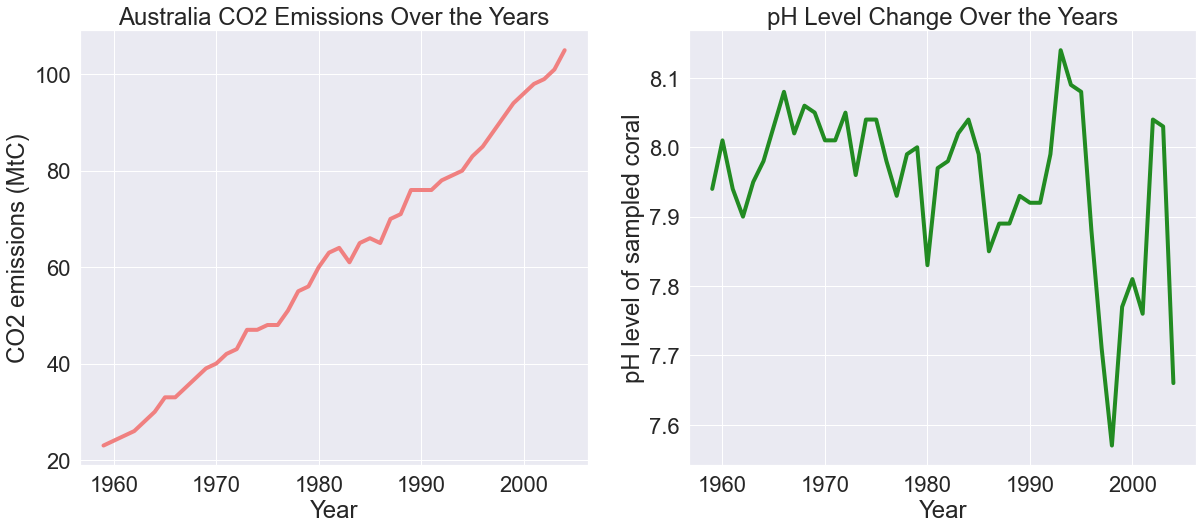

In [6]:
plt.subplot(1,2,1)
plt.plot(df_gbr.index, df_gbr['CO2 emissions (MtC)'], color='lightcoral', linewidth=4)
# set title and x/y labels of left subplot
plt.xlabel('Year')
plt.ylabel('CO2 emissions (MtC)')
plt.gca().title.set_text('Australia CO2 Emissions Over the Years')

plt.subplot(1,2,2)
plt.plot(df_gbr.index, df_gbr['pH'], color='forestgreen', linewidth=4)
# set title and x/y labels of left subplot
plt.xlabel('Year')
plt.ylabel('pH level of sampled coral')
plt.gca().title.set_text('pH Level Change Over the Years')

plt.gcf().set_size_inches(20, 8)

The left graph depicts the change in carbon emissions produced by Australia from 1959 to 2004. The right graph illustrates the change in pH levels of coral sampled along the Great Barrier Reef from 1990 to 2004. It is well documented in science that as the ocean continues to absorb more CO2 in the atmosphere, the pH decreases and the ocean becomes more acidic.

As seen on the left graph, the level of CO2 emissions increases as time goes on. The right graph mimics the expected effects of CO2 on ocean pH levels; as carbon emissions increase there is more carbon for the ocean to absorb so the pH decreases and the ocean becomes more acidic. The sudden drop in pH in 1998 and the subsequent rise is co-incident with a major coral bleaching event. However, the pH level is slowly but surely decreasing over time.
As the CO2 in the atmosphere increases the ocean becomes more acidic and the pH decreases. Keep in mind that similar to global temperature, small change has SIGNIFICANT impact on the ecological balance of the earth.

Many marine organisms (including coral) that produce calcium carbonate shells or skeletons are negatively impacted by increasing CO2 levels and decreasing pH in seawater. Based on these graphs, we can reason that increase of CO2 emissions is correlated with a steady decrease in pH of oceans. With supporting evidence, we know that CO2 is directly responsible for the decrease of the ocean's pH level.

In [7]:
def plot_corr_matrix(df_gbr, col1, col2):
    # find all columns with a given prefix
    column_list = [col for col in df_gbr.columns if col == col1 or col == col2]

    # get dataframe corresponding to column_list
    df = df_gbr.loc[:, column_list]
    print(df.corr())

    # plot
    sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='coolwarm')
    plt.gcf().set_size_inches(10, 10)

                           pH  CO2 emissions (MtC)
pH                   1.000000            -0.447794
CO2 emissions (MtC) -0.447794             1.000000


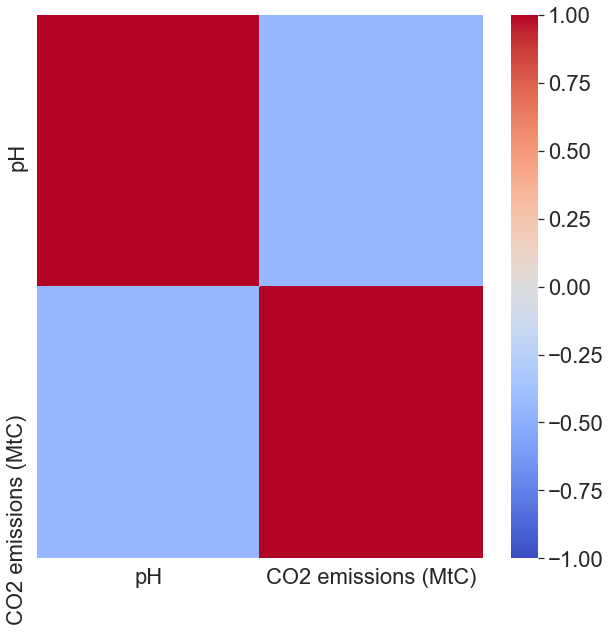

In [8]:
plot_corr_matrix(df_gbr, 'CO2 emissions (MtC)', 'pH')

This correlation matrix indicates that as pH level increases, so does coral calcification. We know this to be true, since ocean acidification (a decrease in pH levels in the ocean), impacts carbon aragonite levels, which is what corals use to build their skeletons. 

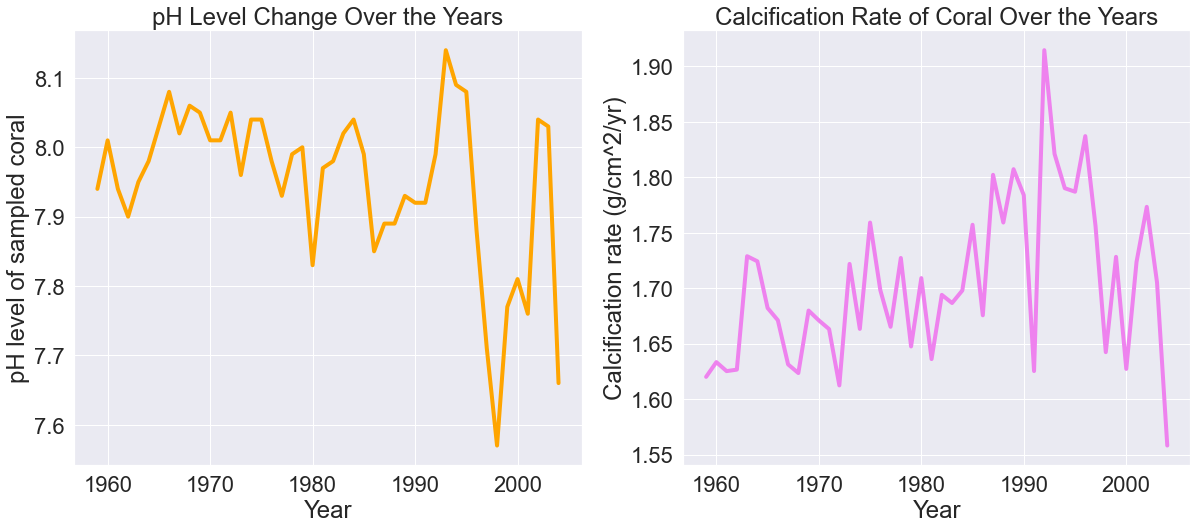

In [9]:
plt.subplot(1,2,1)
plt.plot(df_gbr.index, df_gbr['pH'], color='orange', linewidth=4)
# set title and x/y labels of left subplot
plt.xlabel('Year')
plt.ylabel('pH level of sampled coral')
plt.gca().title.set_text('pH Level Change Over the Years')

plt.subplot(1,2,2)
plt.plot(df_gbr.index, df_gbr['calc rate(g/cm^2/yr)'], color='violet', linewidth=4)
# set title and x/y labels of left subplot
plt.xlabel('Year')
plt.ylabel('Calcification rate (g/cm^2/yr)')
plt.gca().title.set_text('Calcification Rate of Coral Over the Years')

plt.gcf().set_size_inches(20, 8)

The left graph illustrates the change in pH levels of coral sampled along the Great Barrier Reef from 1959 to 2004. The right graph depicts the change in the calcification rate of the sampled coral along the Great Barrier Reef. * The coral sampled for pH levels and growth/calcification rates are different. * For reference, coral calcification is the rate at which reef-building corals lay down their calcium carbonate skeleton. It is a measure of coral growth, which is important for healthy reef ecosystems.

As discussed previously, the pH levels of the left graph reflect the change in carbon emissions and are ultimately decreasing across the time period. The right graph imitates the trend of pH; the the calcification rate increases as the pH increases and the ocean waters are more basic. This is followed by a decline and then a small climb beforing decreases again. The ocean is becoming more acidic as a result of the change in pH which is negatively impacts the abilit for coral to lay their skeleton and thus a depressed calcification rate.

Decreased calcification activity leaves the coral vulnerable to disease, stunts their growth, affects their reproduction, and can impact other species that depend on the coral communities. Coral reefs, including the Great Barrier Reef, are facing unprecedented pressure worldwide due to climate change, changes in water quality from record breaking CO2 emissions among other equally important reasons. 

                          pH  calc rate(g/cm^2/yr)
pH                    1.0000                0.1637
calc rate(g/cm^2/yr)  0.1637                1.0000


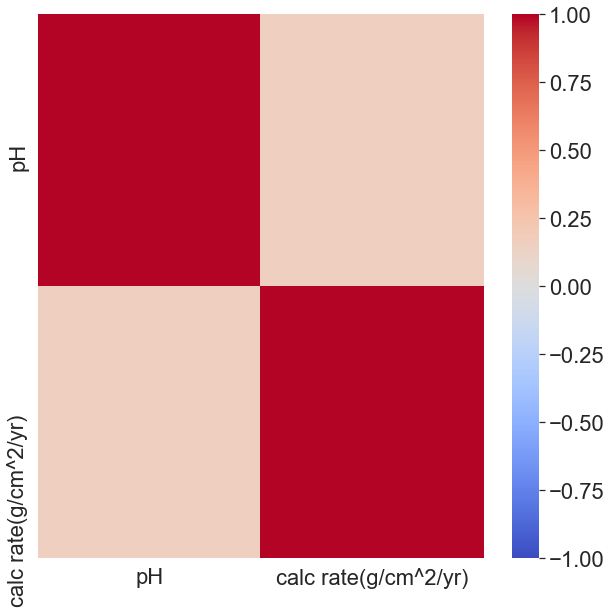

In [10]:
plot_corr_matrix(df_gbr, 'pH', 'calc rate(g/cm^2/yr)')

This correlation matrix indicates that as pH level increases, so does coral calcification. We know this to be true, since ocean acidification (a decrease in pH levels in the ocean), impacts carbon aragonite levels, which is what corals use to build their skeletons. 

## Method

- Project goal: Predict the calcification/growth rate of coral in the Great Barrier Reef
 
To achieve this goal we implemented a multiple regression model. We believe this is the best fit regression model because we want to predict the value of a continuous outcome variable (coral calcification) based on the value of multiple predictor variables (CO2 emissions and pH). To complete this task we were forced to simplify the biological interactions in the world and neglect possible third-party catastrophies or events that can severly impact the ocean. Therefore, we make assumptions that the same societal policies will persist so that there is no drastic change in environmental preservation behavior/attitude, that only CO2 impacts pH level, and only CO2 and pH impact coral growth rate.

As mentioned in the executive summary, we broadly chunked the completion of this method into three different sections. First, we use a linear regression model to predict future carbon dioxide emissions by considering the average of the five preceding years' CO2 values. Secondly, we use a multiple regression model that takes into account the CO2 of a given year and the average of the five preceding years' pH values. Finally, we create a new multiple regression model that considers three variables: CO2 of a given year, pH of a given year, and the average of the preceding five year's calcification rate.


## Results

In [11]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
sns.set(font_scale=2)


In [12]:
def get_linear_regression(df, x_feat_list, y_feat):
    """computes linear regression for specified data and returns intercept and coefficient(s)
    
    Args:
        df (pd.DataFrame) : data
        x_feat_list (list) : list of independent variables to be considered in prediction
        y_feat (String) : variable to predict
    
    Returns:
        intercept, coef (tuple) : model intercept and list of coefficients
    """
    # get target variable
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, y_feat].values
    
    reg = LinearRegression()

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)

    # print model
    model_str = y_feat + f' = {reg.intercept_:.3}'
    for feat, coef in zip(x_feat_list, reg.coef_):
        model_str += f' + {coef:.3} {feat}'
    print(f'Formula for predicting {y_feat}: \n' + model_str)

    # compute r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    print(f'r2 = {r2:.3}')
    
    return (reg.intercept_, reg.coef_)

In [13]:
def create_prev_mean(df, mean_feat):
    """Alters given dataframe by adding new "mean" column that represents the mean of previous 5 years' values
    
    Args:
        df (pd.DataFrame): dataframe we are altering
        mean_feat (str): feature we want to compute mean for
    
    Returns:
        df_mean (pd.DataFrame): dataframe altered with new "mean" for mean_feat
    """

    df_mean = df.copy()
    df_mean.reset_index(inplace=True)
    #print(df_mean)
    year_list = df.index.unique()
    means = []
    
    for i, year in enumerate(year_list):
        
        # years less than 5 are weird because they don't prev 5 years' data, so take mean of available years
        if i < 5:
            sum = 0
            
            # if this is the very first entry, we just set the mean to current entry
            if i == 0:
                mean = df.iloc[i, :][mean_feat]
            else:
                for idx in range(0, i):
                    data = df.iloc[idx, :]
                    sum += data[mean_feat]

                mean = sum / i
                    
        else:
            sum = 0
            # the 5 previous years
            for idx in range(i - 5, i):
                
                data = df.iloc[idx, :]
                sum += data[mean_feat]
            
            mean = sum / 5
        
        means.append(mean)
        
    df_mean[mean_feat + ' mean'] = means
    
    return df_mean

In [14]:
def plot_regression(df, x_feat_list, y_feat, df_predicted=None, title='', xlabel='', ylabel=''):
    """
    Creates scatter plot with linear regression model, plots predicted points if passed in
    
    Args:
        df (pd.DataFrame): dataframe we will base our model on
        x_feat_list (list): x features of linear regression
        y_feat (str): y feature of linear regression
        x_f (np.array): future x data (default=None)
        y_f (np.array): future y data (default=None)
        title (str): title of the plot
        xlabel (str): title of xlabel
        ylabel (str): title of ylabel
    Returns:
        intercept, coef (float, float): intercept and coef of the linear regression
    """
    
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, y_feat].values

    reg = LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(x)

    # compute mean squared error
    mse = ((y_pred - y) ** 2).mean()
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    # plot it
    plt.scatter(df['Year'], y, color='g', label='observed')
    plt.plot(df['Year'], y_pred, color='b', linewidth='3', label='model (regression)')
    max_year = df['Year'].max()
    if df_predicted is not None:
        x_f = df_predicted.loc[:, x_feat_list].values
        y_f = df_predicted.loc[:, y_feat].values
        plt.plot(df_predicted['Year'], y_f, color='r', linewidth='3', label='predicted')
        max_year = df_predicted['Year'].max()
        
    plt.legend()

    sns.set(font_scale=2)
    plt.xticks(np.arange(df['Year'].min(), max_year, 10))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gcf().set_size_inches(15, 10)
    plt.gca().title.set_text(title)

    # print model
    model_str = y_feat + f' = {reg.intercept_:.3}'
    for feat, coef in zip(x_feat_list, reg.coef_):
        model_str += f' + {coef:.3} {feat}'
    print(f'Formula for prediciting {y_feat}: \n' + model_str)

    # compute r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    print(f'r2 = {r2:.3}')
        
    return (reg.intercept_, reg.coef_)

## Predicting CO2

Steps for predicting CO2:
1. Get the CO2 dataframe (do not exclude values past 2004, since we need these to predict future values)
2. Call plot_regression() to visualize this data and get linear regression model
3. Predict CO2 emissions up to 2050 using this linear regression model and add data to df_co2_predicted
4. Call plot_regression again to visualize old data and predicted data
5. Combine df_co2 with df_co2_predicted into df_co2_future. This can now be used to predict pH.

In [15]:
def get_australia_co2(trim_year=False):
    """Gets and cleans historic carbon emmissions data of Autralia into a DataFrame
    
    Args:
        trim_year (bool): do we want to exclude data not within 1959-2004? (default=False)
    
    Returns:
        df_co2 (DataFrame) : DataFrame containing the cleaned carbon emissions data
    """
    df_co2 = pd.read_csv('National_Carbon_Emissions_2020v1.0.csv')
    
    # Set columns to row 10
    df_co2.columns = df_co2.iloc[10]
    
    # remove all rows before row 10
    for index in df_co2.index:
        if index < 10:
            df_co2.drop(index, inplace=True)
            
    # Name the year column and delete nan values
    df_co2.rename(columns={df_co2.columns[0]:'Year'}, inplace=True)
    df_co2 = df_co2[df_co2['Year'].notna()]
    
    # Convert years to ints
    df_co2['Year'] = pd.to_numeric(df_co2['Year'])
    
    if trim_year:
        # we don't want data past 2004
        bool_series = df_co2['Year'] <= 2004
        df_co2 = df_co2.loc[bool_series, :]
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_co2.set_index(['Year'], inplace=True)
    
    
    # only use Australia's co2 emissions
    df_co2 = df_co2.loc[:, df_co2.columns == 'Australia']
    df_co2.rename(columns={df_co2.columns[0]:'CO2 emissions (MtC)'}, inplace=True)   
    df_co2['CO2 emissions (MtC)'] = pd.to_numeric(df_co2['CO2 emissions (MtC)'])

    
    return df_co2

df_co2 = get_australia_co2()
df_co2.head()

10,CO2 emissions (MtC)
Year,
1959,23
1960,24
1961,25
1962,26
1963,28


In [16]:
df_co2_mean = create_prev_mean(df_co2, 'CO2 emissions (MtC)')
df_co2_mean.head()

10,Year,CO2 emissions (MtC),CO2 emissions (MtC) mean
0,1959,23,23.0
1,1960,24,23.0
2,1961,25,23.5
3,1962,26,24.0
4,1963,28,24.5


In [17]:
x_feat_list = ['Year', 'CO2 emissions (MtC) mean']
y_feat = 'CO2 emissions (MtC)'

intercept, coefs = get_linear_regression(df_co2_mean, x_feat_list, y_feat)

df_co2_mean.set_index('Year', inplace=True)

Formula for predicting CO2 emissions (MtC): 
CO2 emissions (MtC) = -1.72e+02 + 0.0909 Year + 0.933 CO2 emissions (MtC) mean
r2 = 0.993


In [18]:
# predict until 2099

df_co2_predicted = pd.DataFrame(columns = ['Year', y_feat, 'CO2 emissions (MtC) mean'])
df_co2_predicted.set_index('Year', inplace=True)

for i in range(0, 2099 - 2019):
    # calculate future co2 mean, will always have 5 previous years so no outlier/weird calculations
    year = 2020 + i 
    co2_sum = 0
    for idx in range(year - 5, year):
        if idx < 2020:
            co2_sum += df_co2_mean.loc[idx]['CO2 emissions (MtC)']
        else:
            co2_sum += df_co2_predicted.loc[idx]['CO2 emissions (MtC)']


    co2_mean = co2_sum / 5
    
    # plug values into formula to calculate predicted pH
    formula = intercept + (coefs[0] * year) + (coefs[1] * co2_mean)
    df_co2_predicted.loc[year] = [formula, co2_mean]

df_co2_predicted.head()

,CO2 emissions (MtC),CO2 emissions (MtC) mean
Year,,
2020,116.482342,112.200000
2021,117.782727,113.496468
2022,118.952577,114.653014
2023,120.154118,115.843529
2024,121.393263,117.074353


<a id='co2_cell'></a>

Formula for prediciting CO2 emissions (MtC): 
CO2 emissions (MtC) = -1.72e+02 + 0.0909 Year + 0.933 CO2 emissions (MtC) mean
r2 = 0.993


(-171.82932202038697, array([0.09091112, 0.93289848]))

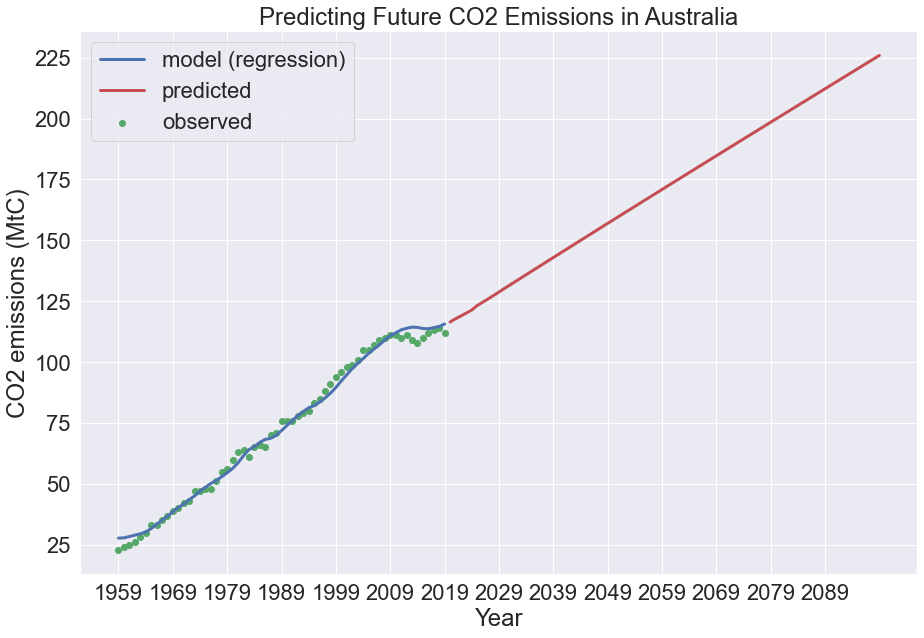

In [19]:
df_co2_predicted.reset_index(inplace=True)
df_co2_mean.reset_index(inplace=True)

plot_regression(df_co2_mean, x_feat_list, y_feat, df_co2_predicted, title='Predicting Future CO2 Emissions in Australia', xlabel='Year', ylabel=y_feat)

### Graph Results

As shown in the graph above, our linear regression model predicts a positive trend between CO2 emissions and year (blue line). Using the year and the mean of the previous 5 years CO2 emissions, we are able to predict that CO2 emissions will keep rising through 2099 (red line).

In [20]:
# add predicted values to df_co2
df_co2_future = pd.concat([df_co2_mean, df_co2_predicted])
df_co2_future = df_co2_future.set_index('Year')

## Predicting pH

Steps for predicting pH:
1. Create ```df_ph_co2``` with pH data (1959 - 2004) and previously constructed ```df_co2``` via ```get_ph_and_co2()```.
2. Rename dataframe as ```df_ph_co2_mean``` and add additional column to represent the average of the previous 5 years' pH levels via ```create_prev_mean()```.
3. Calculate multiple regression model and visualize.
4. Predict pH up to 2050 using this multiple regression model and add data to ```df_ph_predicted```.
5. Plot and visualize predicted multiple regression against observed samples.
6. Extract year and pH information from ```df_ph_predicted``` into ```df_ph_future``` which can now be used to predict coral calcification.

In [21]:
def get_ph_and_co2(df_co2):
    """ Gets pH information and creates combined dataframe with historical co2
    
    Args:
        df_co2 (pd.DataFrame) : dataframe of past future co2 emissions until 2004
    
    Returns:
        df_ph_co2 (pd.DataFrame): dataframe of past 
    """
    df_ph_co2 = pd.read_csv('arlington2009.csv')
    df_ph_co2.dropna(inplace=True)

    # remove unimportant columns
    del df_ph_co2['SampleID']
    del df_ph_co2['        d13C (per mil VPDB) *c']
    del df_ph_co2['        d18O (per mil VPDB) *c']
    del df_ph_co2['        d11B (per mil) *d']
    del df_ph_co2['2sigma']
    del df_ph_co2['   2sigma mean *e']
    del df_ph_co2['      Mg/Ca (x10-3) *b']
    del df_ph_co2['       Sr/Ca (x10-3) *b']
    del df_ph_co2['      Ba/Ca (x10-6)  *b']
    df_ph_co2.columns = ['Year', 'pH']
    
    
    bool_series = df_ph_co2['Year'] >= 1959
    df_ph_co2 = df_ph_co2.loc[bool_series, :]
    
    bool_series = df_ph_co2['Year'] <= 2004
    df_ph_co2 = df_ph_co2.loc[bool_series, :]
    
    # append co2 dataframe to get combined info (both pH and co2)
    df_co2.reset_index(inplace=True)
    df_ph_co2 = pd.merge(df_ph_co2, df_co2, on='Year', how='outer')
    df_ph_co2 = df_ph_co2.astype({"Year": int})
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_ph_co2.set_index(['Year'], inplace=True)
    

    return df_ph_co2

    
df_ph_co2 = get_ph_and_co2(get_australia_co2(True))
df_ph_co2.head()

,pH,CO2 emissions (MtC)
Year,,
1959,7.94,23
1960,8.01,24
1961,7.94,25
1962,7.90,26
1963,7.95,28


In [22]:
df_ph_co2_mean = create_prev_mean(df_ph_co2, 'pH')
df_ph_co2_mean.head()

,Year,pH,CO2 emissions (MtC),pH mean
0,1959,7.94,23,7.940000
1,1960,8.01,24,7.940000
2,1961,7.94,25,7.975000
3,1962,7.90,26,7.963333
4,1963,7.95,28,7.947500


In [35]:
x_feat_list = ['CO2 emissions (MtC)', 'pH mean']
y_feat = 'pH'

intercept, coefs = get_linear_regression(df_ph_co2_mean, x_feat_list, y_feat)

Formula for predicting pH: 
pH = 8.9 + -0.00235 CO2 emissions (MtC) + -0.101 pH mean
r2 = 0.203


In [24]:
df_ph_co2_mean = df_ph_co2_mean.set_index("Year")

In [25]:
# predict until 2099

df_ph_predicted = pd.DataFrame(columns = ['Year', 'CO2 emissions (MtC)', y_feat, 'pH mean'])
df_ph_predicted.set_index('Year', inplace=True)

for i in range(0, 2099 - 2005):
    # calculate future pH mean, will always have 5 previous years so no outlier/weird calculations
    year = 2005 + i 
    ph_sum = 0
    for idx in range(year - 5, year):
        if idx < 2005:
            ph_sum += df_ph_co2_mean.loc[idx][y_feat]
            #print(df_ph_co2_mean.loc[idx][y_feat])
        else:
            ph_sum += df_ph_predicted.loc[idx][y_feat]


    co2 = df_co2_future.loc[year]['CO2 emissions (MtC)']

    ph_mean = ph_sum / 5
    
    # plug values into formula to calculate predicted pH
    formula = intercept + coefs[0] * co2 + coefs[1] * ph_mean
    df_ph_predicted.loc[year] = [co2, formula, ph_mean]

df_ph_predicted.head()

,CO2 emissions (MtC),pH,pH mean
Year,,,
2005,105.0,7.856840,7.860000
2006,107.0,7.851193,7.869368
2007,109.0,7.844647,7.887607
2008,110.0,7.846262,7.848536
2009,111.0,7.847642,7.811788


<a id='ph_cell'></a>

Formula for prediciting pH: 
pH = 8.9 + -0.00235 CO2 emissions (MtC) + -0.101 pH mean
r2 = 0.203


(8.900655482873134, array([-0.00234805, -0.10143394]))

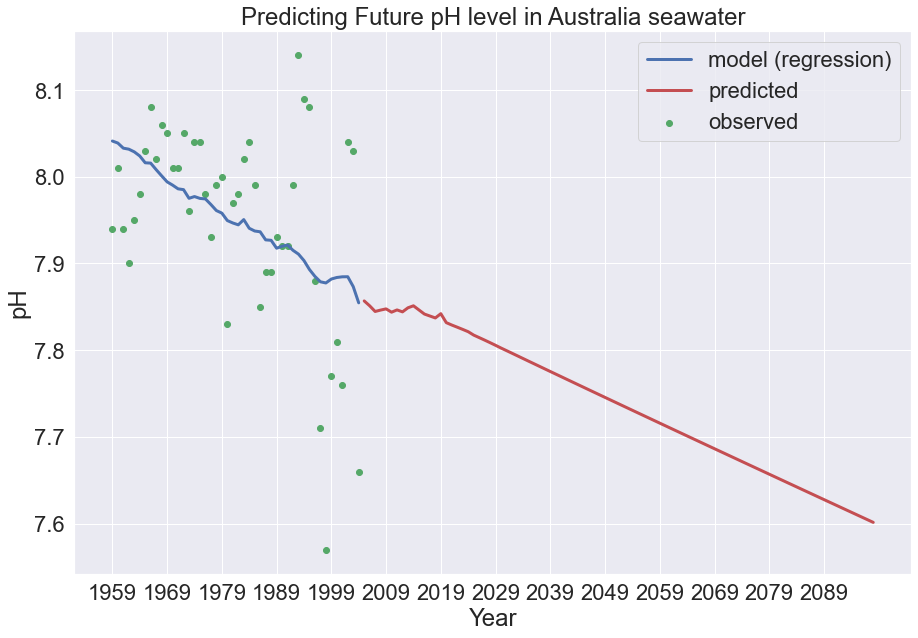

In [26]:
df_ph_predicted.reset_index(inplace=True)
df_ph_co2_mean.reset_index(inplace=True)

plot_regression(df_ph_co2_mean, x_feat_list, y_feat, df_ph_predicted, title='Predicting Future pH level in Australia seawater', xlabel='Year', ylabel=y_feat)

### Graph Results
As shown in the graph above, our linear regression model (blue line) predicts a negative trend between pH level in Australian seawater and year. Using CO2 emissions and the mean of the previous 5 years pH level, we are able to predict that seawater pH level will keep falling through 2099 (red line).

In [27]:
# add predicted values to df_co2
df_ph_future = pd.concat([df_ph_co2_mean, df_ph_predicted])
df_ph_future.set_index('Year', inplace=True)
del df_ph_future['pH mean']

In [28]:
print(df_ph_future.loc[2004])
print(df_ph_future.loc[2050])

pH                       7.66
CO2 emissions (MtC)    105.00
Name: 2004, dtype: float64
pH                       7.742549
CO2 emissions (MtC)    158.362639
Name: 2050, dtype: float64


## Predicting Coral Calcification

Steps for predicting coral calcification:
1. Create ```df_coral``` with coral calcification data (1959 - 2004) and previously constructed ```df_ph_future``` via ```get_coral_ph_co2()```.
2. Rename dataframe as ```df_coral_ph_co2_mean``` and add additional column to represent the average of the previous 5 years' coral calcification levels via ```create_prev_mean()```.
3. Calculate multiple regression model and visualize.
4. Predict coral calcification up to 2050 using this multiple regression model and add data to ```df_coral_predicted```.
5. Plot and visualize predicted multiple regression against observed samples.
6. Extract year and coral calcification information from ```df_coral_predicted``` into ```df_coral_future``` which is the final output of predicting coral calcification until 2050.

In [29]:
def get_coral_ph_co2():
    """Obtains, cleans, and organizes the coral calficiation data into a DataFrame
    
    Returns:
        df_coral (DataFrame) : DataFrame containing the cleaned coral calcification data (including all columns)
    """
    df_coral = pd.read_csv("GBR-coral-calcification.csv")
    df_coral.dropna(axis=0, inplace=True)
    
    del df_coral['Reef']
    del df_coral['ext']
    del df_coral['den']
    df_coral.columns = ['Year', 'id', 'calc rate(g/cm^2/yr)']
    
    
    bool_series = df_coral['Year'] >= 1959 
    df_coral = df_coral.loc[bool_series, :]
    
    bool_series = df_coral['Year'] <= 2004
    df_coral = df_coral.loc[bool_series, :]
    
    df_coral = df_coral.groupby('Year').mean()
    
    # append ph dataframe to get combined info (both coral calc + pH + co2)
    df_ph = df_ph_future.reset_index()
    # get only values earlier than 2005
    series_ph_future = df_ph['Year'] <= 2004
    df_ph = df_ph.loc[series_ph_future, :]
    
    df_coral = pd.merge(df_coral, df_ph, on='Year', how='outer')
    df_coral = df_coral.astype({"Year": int})
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_coral.set_index(['Year'], inplace=True)
    
    return df_coral

df_coral = get_coral_ph_co2()
df_coral.head()
#df_coral = df_coral.loc[df_coral.index > 1989, :]

,calc rate(g/cm^2/yr),pH,CO2 emissions (MtC)
Year,,,
1959,1.620043,7.94,23.0
1960,1.633343,8.01,24.0
1961,1.625227,7.94,25.0
1962,1.626569,7.90,26.0
1963,1.728867,7.95,28.0


In [30]:
df_coral_ph_co2_mean = create_prev_mean(df_coral, 'calc rate(g/cm^2/yr)')
df_coral_ph_co2_mean.head()

,Year,calc rate(g/cm^2/yr),pH,CO2 emissions (MtC),calc rate(g/cm^2/yr) mean
0,1959,1.620043,7.94,23.0,1.620043
1,1960,1.633343,8.01,24.0,1.620043
2,1961,1.625227,7.94,25.0,1.626693
3,1962,1.626569,7.90,26.0,1.626204
4,1963,1.728867,7.95,28.0,1.626295


In [31]:
x_feat_list = ['pH', 'calc rate(g/cm^2/yr) mean']
y_feat = 'calc rate(g/cm^2/yr)'

intercept, coefs = get_linear_regression(df_coral_ph_co2_mean, x_feat_list, y_feat)
df_coral_ph_co2_mean.set_index('Year', inplace=True)

Formula for predicting calc rate(g/cm^2/yr): 
calc rate(g/cm^2/yr) = -1.63 + 0.237 pH + 0.849 calc rate(g/cm^2/yr) mean
r2 = 0.358


In [32]:
# predict until 2099

df_coral_predicted = pd.DataFrame(columns = ['Year','CO2 emissions (MtC)', 'pH', y_feat, 'calc rate(g/cm^2/yr) mean'])
df_coral_predicted.set_index('Year', inplace=True)

for i in range(0, 2099 - 2005):
    year = 2005 + i 
    coral_sum = 0
    for idx in range(year - 5, year):
        if idx < 2005:
            coral_sum += df_coral_ph_co2_mean.loc[idx][y_feat]
        else:
            coral_sum += df_coral_predicted.loc[idx][y_feat]


    co2 = df_ph_future.loc[year]['CO2 emissions (MtC)']
    pH = df_ph_future.loc[year]['pH']

    coral_mean = coral_sum / 5
    
    formula = intercept + (coefs[0] * pH) + coefs[1] * coral_mean
    df_coral_predicted.loc[year] = [co2, pH, formula, coral_mean]

df_coral_predicted

,CO2 emissions (MtC),pH,calc rate(g/cm^2/yr),calc rate(g/cm^2/yr) mean
Year,,,,
2005,105.000000,7.856840,1.661677,1.677508
2006,107.000000,7.851193,1.666186,1.684396
2007,109.000000,7.844647,1.654882,1.672912
2008,110.000000,7.846262,1.635147,1.649217
2009,111.000000,7.847642,1.623574,1.635203
...,...,...,...,...
2094,219.115966,7.613050,1.266999,1.280801
2095,220.485618,7.610130,1.262399,1.276200
2096,221.854933,7.607211,1.257801,1.271599


<a id='result_cell'></a>

Formula for prediciting calc rate(g/cm^2/yr): 
calc rate(g/cm^2/yr) = -1.63 + 0.237 pH + 0.849 calc rate(g/cm^2/yr) mean
r2 = 0.358


(-1.6266908946903262, array([0.23724701, 0.84909075]))

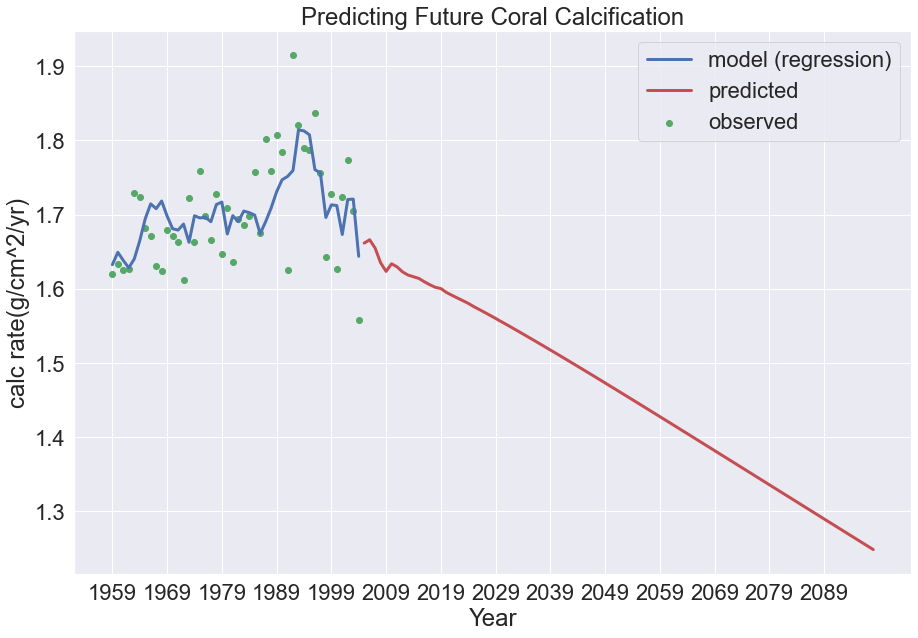

In [33]:
df_coral_predicted.reset_index(inplace=True)
df_coral_ph_co2_mean.reset_index(inplace=True)

plot_regression(df_coral_ph_co2_mean, x_feat_list, y_feat, df_coral_predicted, title='Predicting Future Coral Calcification', xlabel='Year', ylabel=y_feat)

### Graph Results
As shown in the graph above, our linear regression model (blue line) first predicts a slight a positive trend between coral calcification rate of the GBR and year, and then it predicts a negative trend in the more recent years. Using ph level and the mean of the previous 5 years calcification rate, we are able to predict that coral calcification rate will keep falling through 2099 (red line).

## Discusssion

The data gathered shows a negative correlation between CO2 emissions in the atmosphere with pH level in Australian seawater as well as a positive correlation between pH level and coral calcification rate.

The r2 score for predicting CO2 emissions is very high (r2 = 0.9), which shows that the linear regression model is a fairly accurate predictor for CO2 emissions from 2019-2099. However, the r2 score for predicting pH level is low (r2=0.2). This is likely because the points do not follow a linear trend, and rise and fall over the years, with only a negative trend in more recent years. Perhaps using a non-linear model would yield more accurate predictions for the future pH level of Australian seawater. 

Another important point is that from 1959-1998, coral calcification rate is rising, which is the opposite of what we were expecting. After 1998, it drastically falls. This is coincident with a major coral bleaching event. Due to this negative trend and the fact that the linear regression model takes in the mean of the coral calcification rate of the past 5 years as a feature, our model predicts a significant decrease in coral calcification rate in the future. This may not be the most accurate model, since coral bleaching is a feature we do not take into account when predicting pH. The r2 score (r2=0.3) for the coral calcification rate model is slightly higher, but still not sufficient. 

In the future, we would suggest to look into coral calcification data for different types of corals. Ocean acidification causes lower aragonite levels in the ocean, which ultimately decreases coral calcification. With further research, we've discovered that aragonite levels across the Great Barrier Reef itself are not equal; due to currents and circulation (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4766391/). Our model only uses data from one coral sample. Perhaps using data from corals with lower aragonite levels would be more effective and show more of a negative trend in coral calcification rates.

Another potential addition is showing how ocean acidification affects corals in ways other than coral calcification. Ocean acidification also affects the temperature of the seawater, leading to coral bleaching and a decrease in coral reproduction (https://www.sciencedirect.com/science/article/pii/S0025326X09003816?via%3Dihub). With these additional features and data, our model would likely be a better predictor for how ocean acidification is affecting corals

Lastly, in order to make our argument more convincing, we could introduce visuals of how the Great Barrier Reef is shrinking. In order to spark change, we could show data on how using electric vehicles, or making other eco-friendly choices, decreases annual CO2 emissions and therefore helps save the corals.

## Takeaway

Overall, our model may not be the most compelling argument to convince people to make more eco-friendly choices to stop the harm against corals. There are many different factors to consider when predicting coral calcification rates. As discussed above, if we were to find more data and provide more compelling visuals, we could share our work to bring awareness to the dying corals and encourage people to reduce their carbon footprint.